In [ ]:
# Oliver Nagy /19269749 Robert Mooney /19278772
# Code Executes
#mounting drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.9 MB/s 


### **Get Data**

In [ ]:
import numpy as np
import pandas as pd

#Input files below

import os


import copy
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator #preprocessing import
from tensorflow.keras.utils import load_img,img_to_array
from keras.regularizers import l2 #regulariztion import
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
#ifyou  get error for shap run 2nd cell pip install
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split


In [ ]:
#stnadard image dimensions
W = 224
H = 224

#labelling classes within dataSet
label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3


}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)
#gets dataset
def get_images(dir_name='/content/drive/MyDrive/CS4287/Alzheimer_s Dataset', label_to_class=label_to_class):
    """read images / labels from directory"""

    Images = []
    Classes = []
    #combine train and test datasets
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)

    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)

    return Images, Classes

In [ ]:
## get images / labels
Images, Classes = get_images()

Images.shape, Classes.shape

((6400, 224, 224, 3), (6400,))

In [ ]:
## split train / test


indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False) #test and train split 20% to 80%

x_train = Images[indices_train]#traning dataset
y_train = Classes[indices_train]#labels for xtrain
x_test = Images[indices_test]#test dataset
y_test = Classes[indices_test]#labels for ytrain

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 224, 224, 3), (5120,), (1280, 224, 224, 3), (1280,))

In [ ]:
from keras.utils import np_utils
## to one-hot

y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)#converts images to binary values /matrix
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((5120, 4), (1280, 4))

In [ ]:
## to image data generator
from keras.applications.resnet import ResNet50,preprocess_input
#Image Preproccesing
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,                       # randomly rotate images in the range
    width_shift_range=0.15,                   # randomly shift images horizontally
    height_shift_range=0.15,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=True,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

### **CNN model (ResNet50)**

In [ ]:
#  loading the vgg16 model
from keras.layers import Flatten, Dense, BatchNormalization
import keras
# load model
model = keras.models.Sequential() #using sequential model

# load model
ResNet = ResNet50(include_top=False, input_shape=(W,H,3),pooling='avg')   #Defining ResNet50 parameters
print(ResNet.summary())
# Freezing Layers

for layer in ResNet.layers:
    layer.trainable=False
    # below code still constructs a network that is sequential
model.add(ResNet)
model.add(Flatten())#flattening adds an extra channel dimension
model.add(BatchNormalization())#Batch normalisation
#model.add(Dense(32, kernel_regularizer=l2(0.02), bias_regularizer=l2(0.02))) #Regularization = L2 commented it out because of RAM issue
model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))#creates 512 dense layers with relu activation function
model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))#creates 128 dense layers with relu activation function
model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))#creates 32 dense layers with relu activation function
model.add(Dense(n_classes,activation='softmax'))#activation function/layer = softmax  scales numbers/logits into probabilities
model.summary()#displays/prints summary of model

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
model.summary()#Prints model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                        

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau #imports for Keras

In [ ]:

checkpoint_filepath = '{epoch:02d}.h5'
#used to save modell at intervals into .h5 files so that it could be loaded later to continue training
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)
#Stops training if no improvents detected after 5 epochs in a row
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          mode='auto')
#reduces learning rate if no improvements are detected after 3 epochs in a row
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, model_checkpoint_callback, reduce_lr]

In [ ]:
import tensorflow as tf

In [ ]:
# Defining metrics which to evaluate our model by
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

###  Results & Evaluation of the results

In [ ]:
#Compiles model &using ADAM optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),#Learning rate 1e-3
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),#Loss function is Categrical loss entropy
              metrics=METRICS)

epochs = 100#Delcraing number of epochs
#Model fitting gereralizes data
history=model.fit(datagen_train.flow(x_train,y_train, batch_size=128,shuffle=True), epochs=epochs,validation_data=datagen_test.flow(x_test,y_test, batch_size=32,shuffle=True), callbacks=callbacks )
np.save('my_history.npy',history.history)#Saves results


Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.9632 - accuracy: 0.7900 - precision: 0.6126 - recall: 0.4352 - auc: 0.8314
Epoch 1: val_accuracy improved from -inf to 0.77012, saving model to 01.h5
40/40 [==============================] - 73s 1s/step - loss: 0.9632 - accuracy: 0.7900 - precision: 0.6126 - recall: 0.4352 - auc: 0.8314 - val_loss: 1.0283 - val_accuracy: 0.7701 - val_precision: 0.6241 - val_recall: 0.2023 - val_auc: 0.7827 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.8440 - accuracy: 0.8097 - precision: 0.6691 - recall: 0.4723 - auc: 0.8648
Epoch 2: val_accuracy improved from 0.77012 to 0.78926, saving model to 02.h5
40/40 [==============================] - 58s 1s/step - loss: 0.8440 - accuracy: 0.8097 - precision: 0.6691 - recall: 0.4723 - auc: 0.8648 - val_loss: 0.9244 - val_accuracy: 0.7893 - val_precision: 0.6086 - val_recall: 0.4398 - val_auc: 0.8363 - lr: 0.0010
Epoch 3/100
40/40 [========================

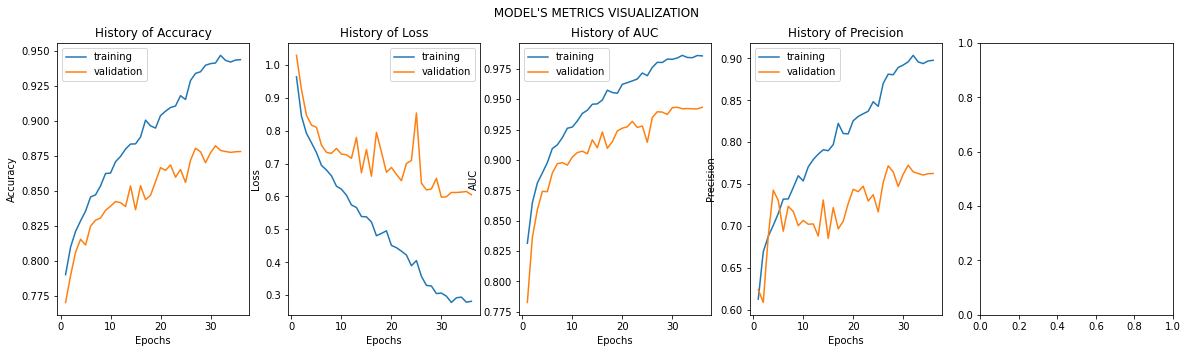

In [ ]:
#PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']              )

In [ ]:
# Predicting model for x_test dataset
predictions=model.predict(x_test)

np.array(predictions)
CATEGORIES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']#label classes for predictions

40/40 [==============================] - 5s 99ms/step


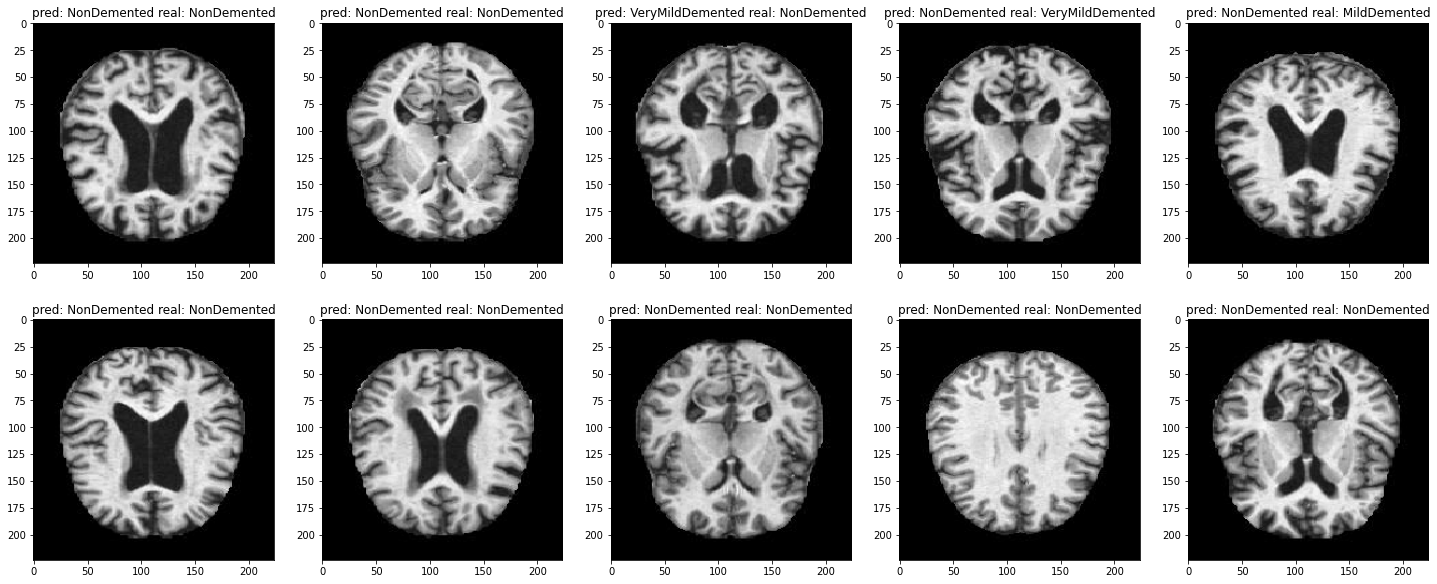

In [ ]:
#Plotting prediction images
rows = 2
columns = 5
fig, axs= plt.subplots(rows, columns , figsize=(25, 10))
axs = axs.flatten()
i=10
for a in axs:

    Image = Images[i]
    pred_label=predictions.argmax(axis=1)[i]
    actual_label=y_test.argmax(axis=1)[i]
    pred_label=CATEGORIES[pred_label]
    actual_label=CATEGORIES[actual_label]
    label= 'pred: '+ pred_label +' '+'real: '+ actual_label

    a.imshow(np.uint8(Image))
    a.set_title(label)
    i=i+1

plt.show()

In [ ]:
# Plot confusion matrix
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
print("F1 Score (testing): %.2f%%"% (f1_score(y_trues, y_preds, average='weighted')*100.0))#print F1 score

In [ ]:
print("accuracy (testing): %.2f%%"% (accuracy_score(y_trues, y_preds)*100.0))#Print testing accuracy

In [ ]:
report = classification_report(y_trues, y_preds)
print(report) #Prints results